# CART and the Random Forest

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import os

## Import data

In [2]:
# where is the working directory set?
os.getcwd()

'/Users/andrewworsley/projects/dat6melb_students/lesson-11/code'

In [3]:
col_admit = pd.read_csv("../assets/dataset/collegeadmissions.csv")

col_admit.head(10)

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


## Parse data

In [4]:
# check parsing
col_admit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


In [5]:
# re-parse
col_admit['admit'] == 1

# create dummy variables
rank_dummy = pd.get_dummies(col_admit['rank'], prefix='rank')

# fuse back
col_admit_clean = pd.concat([col_admit, rank_dummy], axis = 1)

# drop original rank column
col_admit_clean = col_admit_clean.drop(columns = ['rank'])

In [6]:
col_admit_clean.head()

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1


In [7]:
# check parsing
col_admit_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
admit     400 non-null int64
gre       400 non-null int64
gpa       400 non-null float64
rank_1    400 non-null uint8
rank_2    400 non-null uint8
rank_3    400 non-null uint8
rank_4    400 non-null uint8
dtypes: float64(1), int64(2), uint8(4)
memory usage: 11.0 KB


In [8]:
# looks ok
col_admit_clean.head(10)

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
5,1,760,3.00,0,1,0,0
6,1,560,2.98,1,0,0,0
7,0,400,3.08,0,1,0,0
8,1,540,3.39,0,0,1,0
9,0,700,3.92,0,1,0,0


## Model

### Training

Tree & Random Forest

In [9]:
# specifying classifiers - Tree & Random Forest
clf = tree.DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators = 100, oob_score = True, random_state = 123456)

# feature set
X = col_admit_clean.drop(columns = ['admit', "rank_1"])

# target
y = col_admit_clean['admit']

# creating training / testings datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
X_train.head()

,gre,gpa,rank_2,rank_3,rank_4
258,520,3.51,1,0,0
177,620,3.23,0,1,0
119,340,2.92,0,1,0
194,600,3.47,1,0,0
229,720,3.42,1,0,0


In [11]:
print(len(X_train.index))
print(len(X_test.index))

268
132


In [12]:
# fit the classifier# fit t 
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [13]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=123456, verbose=0,
            warm_start=False)

### Testing

In [14]:
# predicted
predicted = clf.predict(X_test)

# predicted probabilities
predictied_prob = clf.predict_proba(X_test)

# actual
validate = pd.DataFrame(y_test)

validate.columns = ['actual']

validate['predicted'] = predicted

# estimated probability of admission
validate['predictied_prob_admit'] = predictied_prob[:,1]

# estimated probability of rejection!
validate['predictied_prob_not_admit'] = predictied_prob[:,0]

validate.head(10)

,actual,predicted,predictied_prob_admit,predictied_prob_not_admit
209,0,0,0.0,1.0
280,0,0,0.0,1.0
33,1,0,0.0,1.0
210,0,0,0.0,1.0
93,0,0,0.0,1.0
84,1,0,0.0,1.0
329,0,0,0.0,1.0
94,1,1,1.0,0.0
266,0,0,0.0,1.0
126,1,0,0.0,1.0


In [15]:
np.sum(validate['actual'] == validate['predicted']) / len(validate)

0.6136363636363636

In [16]:
confusion_matrix(validate['actual'], validate['predicted'])


array([[65, 25],
       [26, 16]])

In [17]:
pd.crosstab(validate['actual'], validate['predicted'], rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,65,25,90
1,26,16,42
All,91,41,132


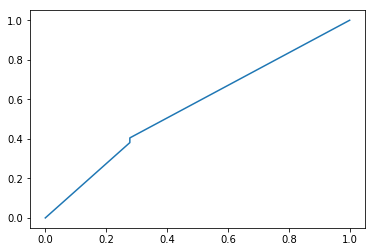

In [18]:
plt.plot(roc_curve(y_test, predictied_prob[:,1])[0], roc_curve(y_test, predictied_prob[:,1])[1])

In [19]:
# predicted
predicted = rf.predict(X_test)

# predicted probabilities
predictied_prob = rf.predict_proba(X_test)

# actual
validate = pd.DataFrame(y_test)

validate.columns = ['actual']

validate['predicted'] = predicted

# estimated probability of admission
validate['predictied_prob_admit'] = predictied_prob[:,1]

# estimated probability of rejection!
validate['predictied_prob_not_admit'] = predictied_prob[:,0]

validate.head(10)

,actual,predicted,predictied_prob_admit,predictied_prob_not_admit
209,0,0,0.155,0.845
280,0,1,0.870,0.130
33,1,0,0.340,0.660
210,0,0,0.100,0.900
93,0,0,0.140,0.860
84,1,0,0.080,0.920
329,0,0,0.000,1.000
94,1,1,0.600,0.400
266,0,0,0.050,0.950
126,1,1,0.550,0.450


In [20]:
# overal accuracy... be careful!!
np.sum(validate['actual'] == validate['predicted']) / len(validate)

0.6818181818181818

In [21]:
confusion_matrix(validate['actual'], validate['predicted'])

array([[72, 18],
       [24, 18]])

In [22]:
pd.crosstab(validate['actual'], validate['predicted'], rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,72,18,90
1,24,18,42
All,96,36,132


Note: When predicited_prob_admit > 0.5 we predict that the student will be admitted!!

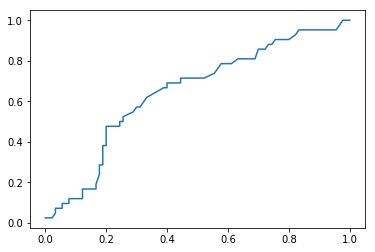

In [23]:
plt.plot(roc_curve(y_test, predictied_prob[:,1])[0], roc_curve(y_test, predictied_prob[:,1])[1])

Is this a good model? What about error? We we have just done one shot here... perhaps we can use cross-vailidation to get a better idea of the model performance.

### Variable Importance Measure

In [24]:
rf.feature_importances_

array([0.34619622, 0.54209536, 0.04222778, 0.04428664, 0.025194  ])

In [25]:
important_features = dict(zip(X_train.columns, list(rf.feature_importances_)))

In [26]:
for feature, importance in important_features.items():
    print(str(feature) + " " + str(round(importance, 2)))

gre 0.35
gpa 0.54
rank_2 0.04
rank_3 0.04
rank_4 0.03
